In [25]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import cm
import tensorflow as tf
import keras
import logging

logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)

In [7]:
def load_coffee_data():
    """Creates a coffee roasting data set.
    roasting duration: 12-15 minutes is best
    temperature range: 175-260C is best
    """
    rng = np.random.default_rng(2)
    X = rng.random(400).reshape(-1, 2)
    X[:, 1] = X[:, 1] * 4 + 11.5  # 12-15 min is best. [0, 1) -> [0, 4) -> [11.5, 15.5)
    X[:, 0] = (
        X[:, 0] * (285 - 150) + 150
    )  # 350-500 F (175-260 C) is best [0, 1) -> [0, 135) -> [150, 285)
    Y = np.zeros(len(X))

    i = 0
    for t, d in X:
        y = -3 / (260 - 175) * t + 21
        if (
            t > 175 and t < 260 and d > 12 and d < 15 and d <= y
        ):  # d <= y is for the area under the slanted line, not the whole rectangle
            Y[i] = 1
        else:
            Y[i] = 0
        i += 1
    return (X, Y.reshape(-1, 1))

In [8]:
X, Y = load_coffee_data()
print(X.shape, Y.shape)

(200, 2) (200, 1)


In [9]:
def plt_roast(X, Y):
    Y = Y.reshape(
        -1,
    )
    pos = Y == 1
    neg = ~pos
    _, ax = plt.subplots(1, 1)
    ax.scatter(X[pos, 0], X[pos, 1], s=70, marker="x", c="r", label="Good Roast")
    ax.scatter(
        X[neg, 0],
        X[neg, 1],
        s=90,
        marker="o",
        facecolors="none",
        edgecolors="b",
        lw=1,
        label="Bad Roast",
    )
    tr = np.linspace(175, 260, 50)
    ax.plot(tr, -3 / 85 * tr + 21, c="purple", lw=1)
    ax.axhline(y=12, c="purple", lw=1)
    ax.axvline(x=175, c="purple", lw=1)
    ax.set_title("Coffee Roasting")
    ax.set_ylabel("Duration \n(minutes)")
    ax.set_xlabel("Temperature \n(Celsius)")
    ax.legend(loc="upper right")
    plt.show()

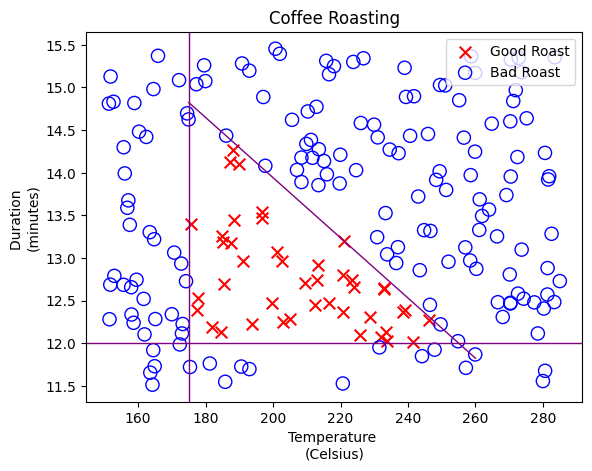

In [10]:
plt_roast(X, Y)

In [11]:
print(
    f"Temperature Max, Min pre normalization: {np.max(X[:,0]):0.2f}, {np.min(X[:,0]):0.2f}"
)
print(
    f"Duration    Max, Min pre normalization: {np.max(X[:,1]):0.2f}, {np.min(X[:,1]):0.2f}"
)
norm_l = keras.layers.Normalization(axis=-1)
norm_l.adapt(X)  # learns mean, variance
Xn = norm_l(X)
print(
    f"Temperature Max, Min post normalization: {np.max(Xn[:,0]):0.2f}, {np.min(Xn[:,0]):0.2f}"
)
print(
    f"Duration    Max, Min post normalization: {np.max(Xn[:,1]):0.2f}, {np.min(Xn[:,1]):0.2f}"
)

Temperature Max, Min pre normalization: 284.99, 151.32
Duration    Max, Min pre normalization: 15.45, 11.51
Temperature Max, Min post normalization: 1.66, -1.69
Duration    Max, Min post normalization: 1.79, -1.70


In [12]:
def sigmoid(z):
    z = np.asarray(z, dtype=np.float32)
    return np.where(z >= 0, 1 / (1 + np.exp(-z)), np.exp(z) / (1 + np.exp(z)))

In [13]:
g = sigmoid

In [14]:
def my_dense(a_in, W, b):
    """
    Computes dense layer
    Args:
      a_in (ndarray (n, )) : Data
      W    (ndarray (n,j)) : Weight matrix, n features per unit, j units
      b    (ndarray (j, )) : bias vector, j units
    Returns
      a_out (ndarray (j,))  : j units|
    """
    z = a_in @ W + b
    return g(z)

In [15]:
def my_sequential(x, W1, b1, W2, b2):
    a1 = my_dense(x, W1, b1)
    a2 = my_dense(a1, W2, b2)
    return a2

In [16]:
W1_tmp = np.array([[-8.93, 0.29, 12.9], [-0.1, -7.32, 10.81]])
b1_tmp = np.array([-9.82, -9.28, 0.96])
W2_tmp = np.array([[-31.18], [-27.59], [-32.56]])
b2_tmp = np.array([15.41])

In [17]:
def my_predict(X, W1, b1, W2, b2):
    return my_sequential(X, W1, b1, W2, b2)

In [18]:
X_tst = np.array([[200, 13.9], [200, 17]])  # postive example  # negative example
X_tstn = norm_l(X_tst)  # remember to normalize
predictions = my_predict(X_tstn, W1_tmp, b1_tmp, W2_tmp, b2_tmp)

In [19]:
yhat = (predictions >= 0.5).astype(int)
print(yhat)

[[1]
 [0]]


In [26]:
# Plots the heat map of the Input surface
def plt_prob(ax, fwb):
    """plots a decision boundary but include shading to indicate the probability"""
    # setup useful ranges and common linspace
    t_space = np.linspace(150, 285, 40)
    d_space = np.linspace(11.5, 15.5, 40)
    T, D = np.meshgrid(t_space, d_space)
    grid_points = np.c_[T.ravel(), D.ravel()]
    Z = fwb(grid_points)
    Z = Z.reshape(T.shape)

    # # 1. Grab the "Blues" palette and sample only the first 50% (0.0 to 0.5)
    # new_colors = plt.get_cmap('Blues')(np.linspace(0.0, 0.5, 256))

    # # 2. Turn those colors back into a usable colormap object
    # new_cmap = ListedColormap(new_colors)
    cmap = ListedColormap(plt.get_cmap("Blues")(np.linspace(0.0, 0.5, 256)))
    pcm = ax.pcolormesh(
        T,
        D,
        Z,
        norm=cm.colors.Normalize(vmin=0, vmax=1),
        cmap=cmap,
        shading="nearest",
        alpha=0.9,
    )
    ax.figure.colorbar(pcm, ax=ax)

In [27]:
def plt_network(X, Y, netf):
    fig, ax = plt.subplots(1, 2, figsize=(16, 4))
    Y = Y.reshape(
        -1,
    )
    plt_prob(ax[0], netf)
    ax[0].scatter(
        X[Y == 1, 0], X[Y == 1, 1], marker="x", c="r", s=70, label="Good Roast"
    )
    ax[0].scatter(
        X[~(Y == 1), 0],
        X[~(Y == 1), 1],
        marker="o",
        facecolors="none",
        edgecolors="b",
        lw=1,
        s=90,
        label="Bad Roast",
    )
    ax[0].set_title(f"network probability")
    fwb = netf(X)
    # print(f"yhat = {(fwb >= 0.5).astype(int)})
    pos = (fwb >= 0.5).ravel()
    neg = ~pos
    ax[1].scatter(
        X[pos, 0], X[pos, 1], marker="x", c="orange", s=70, label="Predicted Good Roast"
    )
    ax[1].scatter(
        X[neg, 0],
        X[neg, 1],
        marker="o",
        facecolors="none",
        edgecolors="b",
        lw=1,
        s=90,
        label="Predicted Bad Roast",
    )
    for axes in ax:
        axes.plot(X[:, 0], (-3 / 85) * X[:, 0] + 21, color="purple", lw=1)
        axes.axhline(y=12, color="purple", lw=1)
        axes.axvline(x=175, color="purple", lw=1)
        axes.set_xlabel("Temperature \n(Celsius)", size=12)
        axes.set_ylabel("Duration \n(minutes)", size=12)
        axes.legend(loc="upper right")

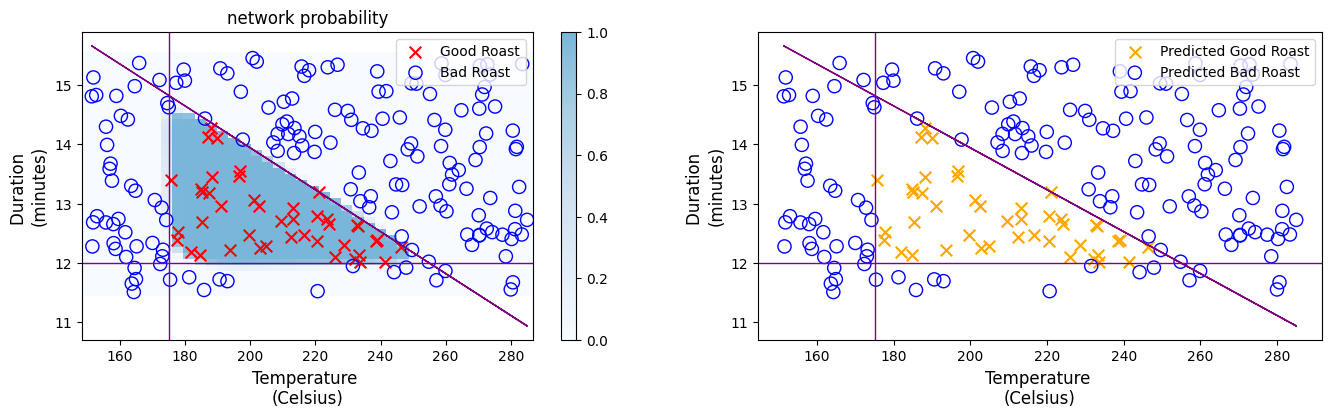

In [28]:
netf = lambda x: my_predict(norm_l(x), W1_tmp, b1_tmp, W2_tmp, b2_tmp)
plt_network(X, Y, netf)